# IMPORTING LIB & OTHERS

In [2]:
from google.colab import files

In [3]:
files = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle/

In [5]:
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
import numpy as np
import os
from PIL import Image

#Visualization and evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.math import confusion_matrix

# Net libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 319M/330M [00:02<00:00, 101MB/s] 
100% 330M/330M [00:02<00:00, 123MB/s]


In [8]:
!unzip face-mask-12k-images-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: dataset/Face Mask Dataset/Train/WithoutMask/1868.png

In [9]:
path = '../content/dataset/Face Mask Dataset/'
with_mask = path+'/Train/WithMask/1035.png'
without_mask= path+'/Train/WithoutMask/10.png'

BATCH_SIZE = 64
EPOCHS = 8
TARGET_SIZE = (128,128)
CLASSES = ['Without Mask' ,'With Mask']

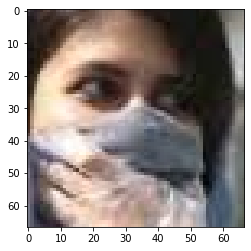

In [10]:
plt.imshow(load_img(with_mask))

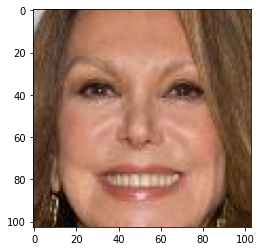

In [11]:
plt.imshow(load_img(without_mask))

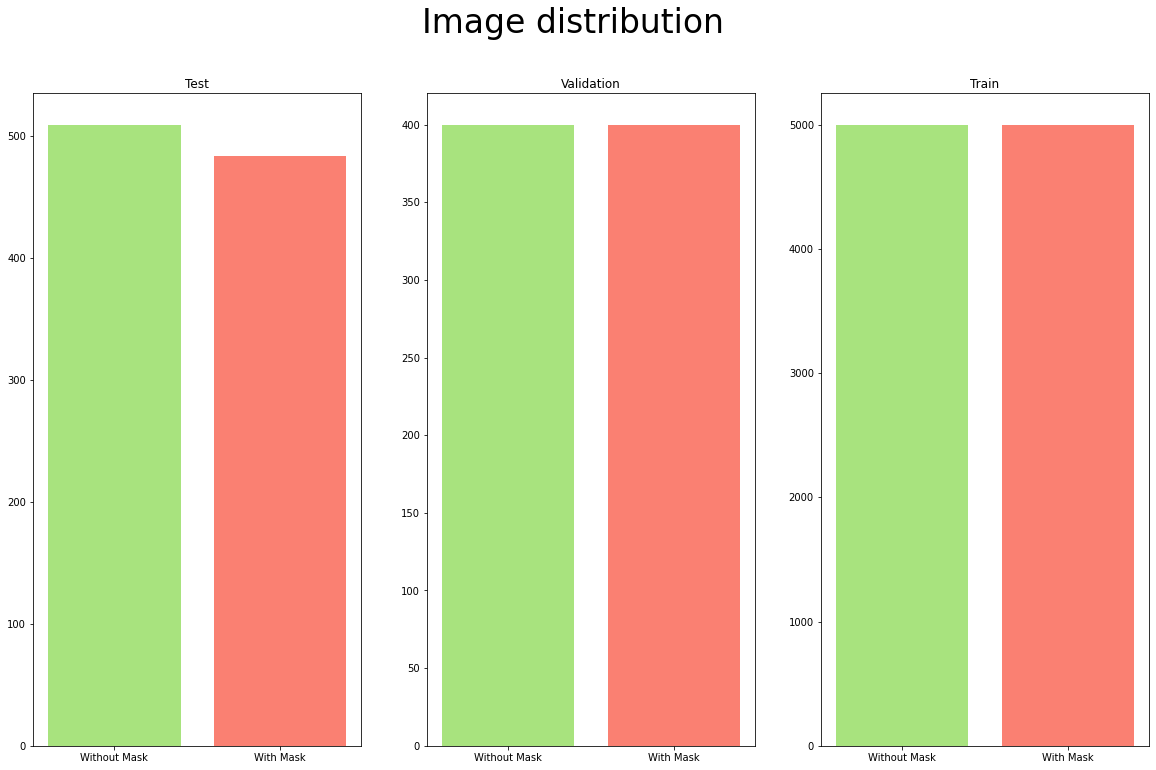

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 12))

for set_ in os.listdir(path):
    total = []
    ax = axes[os.listdir(path).index(set_)]
    for class_ in os.listdir(path+'/'+set_):
        count=len(os.listdir(path+'/'+set_+'/'+class_))
        total.append(count)
    ax.bar(CLASSES, total, color=['#a8e37e','#fa8072'])
    ax.set_title(set_)
plt.suptitle('Image distribution', size=33)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

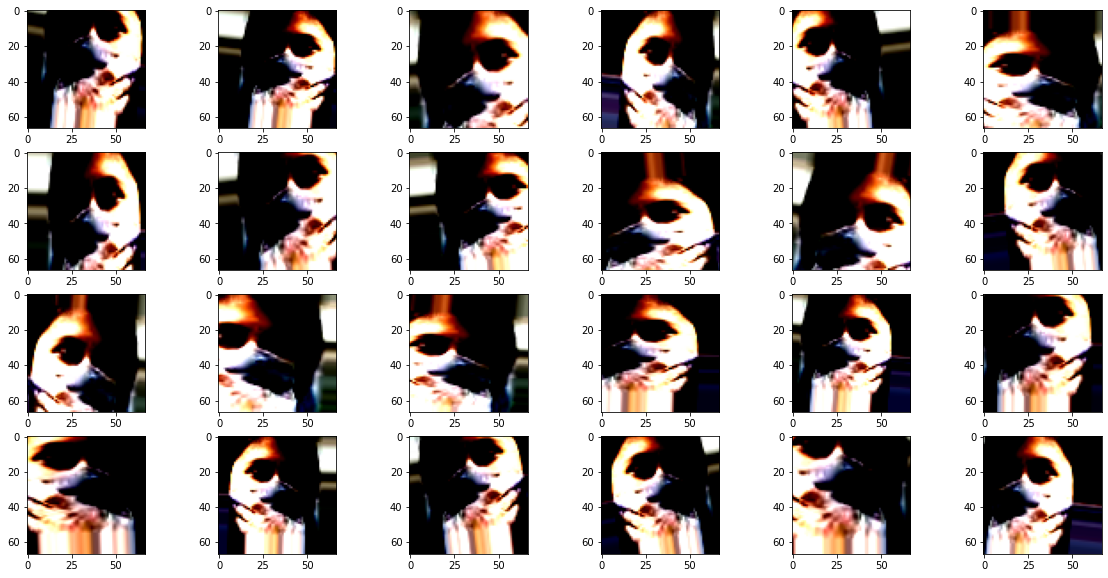

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

img = load_img(with_mask)
example_aug = img_to_array(img)/255

example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))
for i,img in enumerate(train_datagen.flow(example_aug,batch_size=1)):
  plt.subplot(4,6,i+1)
  plt.imshow(np.squeeze(img))
  if i==23:
    break

plt.show()

In [14]:
train_set = train_datagen.flow_from_directory(directory=path+'Train',
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical',
                                              target_size=TARGET_SIZE)
validation_set = test_datagen.flow_from_directory(directory=path+'Validation',
                                                  target_size=TARGET_SIZE,
                                                  )


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [15]:
def create_model():
  denseNet_model = DenseNet201(input_shape=TARGET_SIZE + (3,),weights='imagenet',
                               include_top=False)
  denseNet_model.trainable = False
  flatten = Flatten ()(denseNet_model.layers[-1].output)
  fc = Dense(units=412,activation='relu')(flatten)
  dropout = Dropout(0.35)(fc)
  output = Dense(2,activation='softmax')(dropout)

  model = Model(inputs=denseNet_model.input, outputs=output)
  model.summary()
  return model

model = create_model()

74842112/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [16]:
starter_learning_rate = 1e-2
end_learning_rate = 1e-6
decay_steps = 10000
learning_rate = optimizers.schedules.PolynomialDecay(starter_learning_rate,decay_steps,end_learning_rate,power=0.4)

In [17]:
opt = optimizers.Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [18]:
my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=5, mode='auto',restore_best_weights=False, verbose=1),
                ModelCheckpoint(filepath='my_model.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
]

In [19]:
history = model.fit(train_set,
                    epochs=EPOCHS, steps_per_epoch=len(train_set), # How many mini_batchs we have inside each epoch.
                    validation_data=validation_set,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model.h5')
#model.save_weights("my_model.h5")

Epoch 1/8
157/157 [==============================] - 95s 349ms/step - loss: 8.6493 - accuracy: 0.9729 - val_loss: 0.0025 - val_accuracy: 0.9987

Epoch 00001: accuracy improved from -inf to 0.97290, saving model to my_model.h5
Epoch 2/8
157/157 [==============================] - 49s 313ms/step - loss: 0.0548 - accuracy: 0.9921 - val_loss: 0.0076 - val_accuracy: 0.9975

Epoch 00002: accuracy improved from 0.97290 to 0.99210, saving model to my_model.h5
Epoch 3/8
157/157 [==============================] - 49s 312ms/step - loss: 0.0227 - accuracy: 0.9944 - val_loss: 0.0075 - val_accuracy: 0.9962

Epoch 00003: accuracy improved from 0.99210 to 0.99440, saving model to my_model.h5
Epoch 4/8
157/157 [==============================] - 49s 314ms/step - loss: 0.0163 - accuracy: 0.9955 - val_loss: 0.0054 - val_accuracy: 0.9987

Epoch 00004: accuracy improved from 0.99440 to 0.99550, saving model to my_model.h5
Epoch 5/8
157/157 [==============================] - 50s 320ms/step - loss: 0.0122 - ac

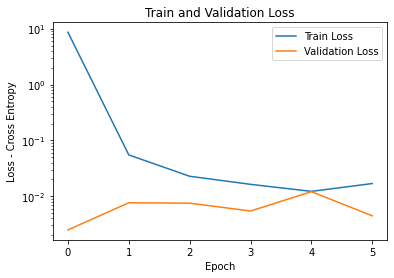

In [20]:
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
plt.semilogy(train_loss, label='Train Loss')
plt.semilogy(val_loss, label='Validation Loss')


plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss - Cross Entropy')
plt.title('Train and Validation Loss')


plt.show()

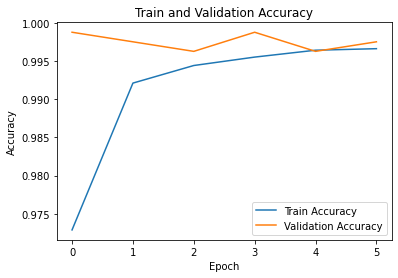

In [22]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch'),
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.show()

In [23]:
test_set = test_datagen.flow_from_directory(path + 'Test',target_size=TARGET_SIZE,shuffle=False)

Found 992 images belonging to 2 classes.


In [24]:
# Model Evaluate 
loss, accuracy = model.evaluate(test_set)
print('Test Accuracy: ', '\033[1m',round(accuracy*100, 2),'%\033[0m')

31/31 [==============================] - 2s 77ms/step - loss: 0.0179 - accuracy: 0.9909
Test Accuracy:   99.09 %


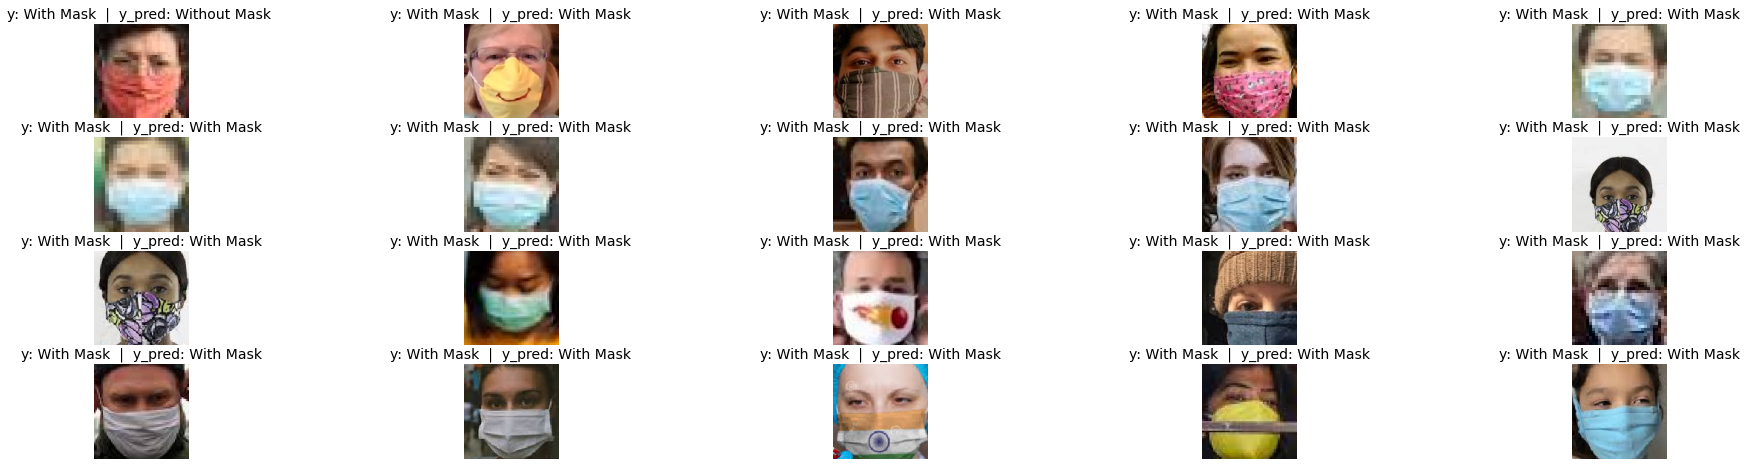

In [25]:
# True Label & Predict of a particular Batch
image, label = test_set.next()
num_imgs = 20
lab_names = ['With Mask','Without Mask ']
images = image[0:num_imgs,:,:,:]
labels = label[0:num_imgs,:]
predict = np.round(model.predict(images))

image_rows = 4
image_col = int(num_imgs/image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i,:,:,:]
    lab = labels[i,:]
    axs[i].imshow(img)
    pred = predict[i]
    axs[i].axis('off')
    lab, pred = np.argmax(lab), np.argmax(pred)
    axs[i].set_title(label = f'y: {lab_names[lab]}  |  y_pred: {lab_names[pred]}', fontsize=14)

plt.show()

In [26]:
y_pred = model.predict(test_set).argmax(axis=-1)
y_test = test_set.classes

Confusion_Matrix = confusion_matrix(y_test,y_pred)

Text(0.5, 1.0, 'Confusion matrix')

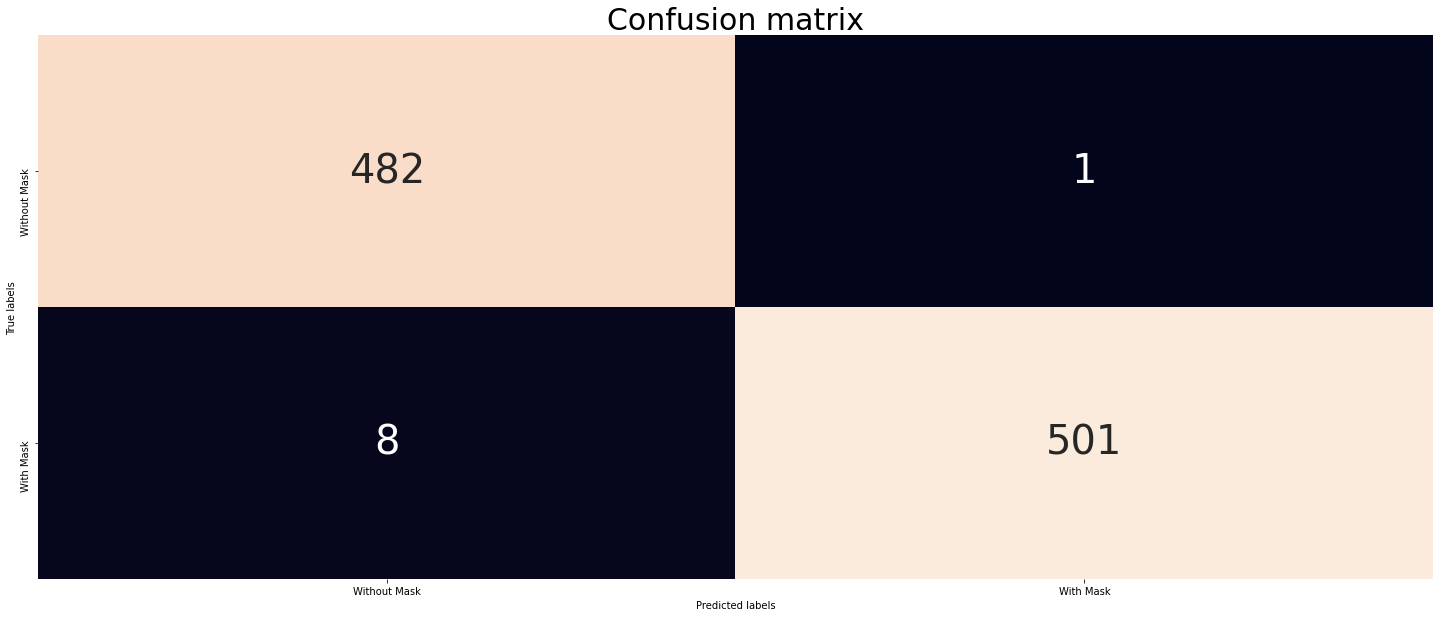

In [27]:
fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(Confusion_Matrix,xticklabels=CLASSES,yticklabels=CLASSES, ax=ax, annot=True,fmt="1.0f",cbar=False,annot_kws={"size": 40})
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.title("Confusion matrix",fontsize=30)

In [28]:
model.save('my_model.h5')

In [35]:
tflite_model = tf.keras.models.load_model('/content/my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("my_model.tflite", "wb").write(tflite_save)  

INFO:tensorflow:Assets written to: /tmp/tmpqc0irfvl/assets


123121984